# Predicción de pérdida de clientes en Empresas de Servicios de Telecomunicaciones (Churn)

Reducir las salidas y [deserciones de clientes](https://www.bain.com/insights/breaking-the-back-of-customer-churn/) se ha convertido en una alta prioridad para la mayoría de los proveedores de servicios de comunicaciones a medida que los mercados maduran y la competencia se intensifica.




En este documento usaremos una base de datos de una empresa de telecomunicaciones anónima [disponibilizada por IBM](https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv). 

El principal objetivo es crear un model de aprendizaje automático basado en SVM y Regresión Logística (Logistic Regression, LR) para predecir la pérdida o salida de clientes en una empresa de telecomunicaciones.


## Librerías

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report  
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures


## Base de datos

Este conjunto de datos contiene un total de 7043 clientes y 21 características de los mismos. De las entradas, 5174 son clientes activos y 1869 son clientes que la empresa ha perdido. Observe que el conjunto de datos está desbalanceado pues por cada cliente perdido existe casi 3 clientes activos. La variable de salida para nuestro modelo de machine learning será `Churn`.

In [ ]:
# importamos dataset
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# vemos las primeras 5 filas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### *Detalles de la base de datos*

*	`customerID` - Custumer unique identifier
*	`gender` - Customer gender - ['Female' 'Male']
*	`SeniorCitizen` - Elderly or retired person, a senior citizen is someone who has at least attained the age of 60 of 65 years
*	`Partner` - - ['No' 'Yes']
*	`Dependents` - If customer has dependents - ['No' 'Yes']
*	`Tenure` - Customer lifespan (in months)
*	`PhoneService` - - ['No' 'Yes']
*	`MultipleLines` - - ['No' 'No phone service' 'Yes']
*	`InternetService` - - ['No' 'No internet service' 'Yes']
*	`OnlineSecurity` - - ['No' 'No internet service' 'Yes']
*	`OnlineBackup` - - ['No' 'No internet service' 'Yes']
*	`DeviceProtection` - - ['No' 'No internet service' 'Yes']
*	`TechSupport` - - ['No' 'No internet service' 'Yes']
*	`StreamingTV` - - ['No' 'No internet service' 'Yes']
*	`StreamingMovies` -  - ['No' 'No internet service' 'Yes']
*	`Contract` - Type of contract - ['Month-to-month' 'One year' 'Two year']
*	`PaperlessBilling` - - ['No' 'Yes']
*	`PaymentMethod` - payment method - ['Bank transfer (automatic)', 'Credit card (automatic)', 'Electronic check', 'Mailed check']
*	`MonthlyCharges` - Monthly Recurring Charges
*	`TotalCharges` - Life time value
*	`Churn` - Churn value, the targer vector - ['No' 'Yes']





### *Limpieza del Dataset*

In [ ]:
def get_df_size(df, header='Dataset dimensions'):
  print(header,
        '\n# Attributes: ', df.shape[1], 
        '\n# Entries: ', df.shape[0],'\n')
  
get_df_size(df)

#df.info()

# reemplaza valores en blanco por NaN 
df_clean = df.replace(r'^\s*$', np.nan, regex=True)

# reemplaza valores faltantes en TotalCharges por la mediana de TotalCharges.
total_charges_median = df_clean.TotalCharges.median()
df_clean['TotalCharges'].fillna(total_charges_median, inplace=True)
df_clean['TotalCharges'] = df_clean['TotalCharges'].apply(pd.to_numeric)

#CustomerID lo retiramos porque no es una característica
df_clean = df_clean.drop('customerID', axis=1)
df_clean.describe()

print("Churn No Instances: ", df_clean[df_clean['Churn'] == 'No'].shape[0])
print("Churn Yes Instances: ", df_clean[df_clean['Churn'] == 'Yes'].shape[0])


Dataset dimensions 
# Attributes:  21 
# Entries:  7043 

Churn No Instances:  5174
Churn Yes Instances:  1869


## Preparación de la Base de Datos








In [ ]:
binary_feat = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
numeric_feat = [col for col in df_clean.select_dtypes(['float','int']).columns.tolist() if col not in binary_feat]
categorical_feat = [ col for col in df_clean.select_dtypes('object').columns.to_list() if col not in binary_feat + numeric_feat ]
df_proc = df_clean.copy()
#Etiquetas para características binarias
le = LabelEncoder()
for i in binary_feat:
  df_proc[i] = le.fit_transform(df_proc[i])
  print(i, '\n', np.unique(df_proc[i].values))
#Dummy variables
df_proc = pd.get_dummies(df_proc, columns=categorical_feat)
get_df_size(df, header='Original dataset:')
get_df_size(df_proc, header='Processed dataset:')
df_proc.head()

gender 
 [0 1]
SeniorCitizen 
 [0 1]
Partner 
 [0 1]
Dependents 
 [0 1]
PhoneService 
 [0 1]
PaperlessBilling 
 [0 1]
Churn 
 [0 1]
Original dataset: 
# Attributes:  21 
# Entries:  7043 

Processed dataset: 
# Attributes:  41 
# Entries:  7043 



,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


### *División en conjunto de entrenamiento y test*

In [ ]:
# dividimos df_proc en características y salida
X=df_proc.drop('Churn', axis=1)
y=df_proc['Churn']

# Dividimos el conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Actividad 1: Visualización con TSNE 
Utilice TSNE para visualizar su dataset de entrenamiento. Recuerde normalizar su dasaset (zscore) antes de esta y las siguientes actividades. 

In [ ]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#Entrenamiento 
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X_train_norm) 


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5634 samples in 0.000s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 5634 samples in 1.940s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5634
[t-SNE] Computed conditional probabilities for sample 2000 / 5634
[t-SNE] Computed conditional probabilities for sample 3000 / 5634
[t-SNE] Computed conditional probabilities for sample 4000 / 5634
[t-SNE] Computed conditional probabilities for sample 5000 / 5634
[t-SNE] Computed conditional probabilities for sample 5634 / 5634
[t-SNE] Mean sigma: 0.351805
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.720955
[t-SNE] KL divergence after 1000 iterations: 1.323269


[]

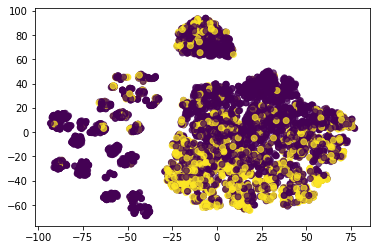

In [ ]:
plt.scatter(x=z[:,0],y=z[:,1],c=y_train,alpha=0.7)
plt.plot()

### Actividad 2: Clasificador y Optimización de Hiperparámetros SVM

Cree un clasificador con SVM (ver `SVC`) con kernel RBF.
Use 5-fold cross-validation (ver `GridSearchCV` y  `StratifiedKFold`) para optimizar los siguientes hiperparámetros en el conjunto de entrenamiento (`X_train`, `y_train`):

1. Gamma 
2. C

Para la optimización de hiperparámetros utilice como métrica al recall.

Una vez optimizados los hiperparámetros, reentrene su clasificador con los mejores hiperparámetros encontrados. Finalmente, evalúe este último clasificador en el conjunto de test ('X_test', 'y_test'.)


In [ ]:
#Optimizacion de hyperparametros
skf = StratifiedKFold(n_splits=5)
gamma=['scale','auto']
C=[0.25,0.5,0.75,1,2,3,4]
param_grid=dict(gamma=gamma,
                C=C)
modelSVC = SVC(kernel='rbf')
grid=GridSearchCV(modelSVC,param_grid,scoring='recall',cv=skf)
grid_search=grid.fit(X_train_norm,y_train)
print(grid_search.best_params_)

{'C': 3, 'gamma': 'scale'}


In [ ]:
modelSVC = SVC(kernel='rbf',C=3,gamma='scale')
modelSVC.fit(X_train_norm, y_train) #entrenamiento
#performance conjunto de test
pred_test = modelSVC.predict(X_test)
acc_test = metrics.accuracy_score(y_test, pred_test)
recall_test = metrics.recall_score(y_test, pred_test)
precision_test=metrics.precision_score(y_test,pred_test)
print("Recall test = ", recall_test, ", acc test = ", acc_test,", prec test = ", precision_test,)

Recall test =  0.5240641711229946 , acc test =  0.7828246983676366 , prec test =  0.6049382716049383


### Actividad 3: Clasificador y Optimización de Hiperparámetros Logistic Regression

Repita la actividad 2 pero con Logistic Regression. Bajo el mismo esquema de la actividad anterior, optimice el parámetro de regularización lambda. Utilice una transformación polinomial para garantizar fronteras de decisión no lineal. Compare sus resultados con los obtenidos de la actividad anterior

In [ ]:
# Dividimos el conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
#Optimizacion de hyperparametros
skf = StratifiedKFold(n_splits=5)
C=[1/3,1/2,1/4,1/5,1]
poly=PolynomialFeatures(3)
X_train_pol=poly.fit_transform(X_train)
X_train_norm=scaler.fit_transform(X_train_pol)
param_grid=dict(C=C)
regr = LogisticRegression(penalty='l2')
grid=GridSearchCV(regr,param_grid,scoring='recall',cv=skf)
grid_search=grid.fit(X_train_norm,y_train)
print(grid_search.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'C': 0.25}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


A pesar de los errores obtenidos por el desbalanceo del dataset de iteracion se sabe que el mejor parametro de C es 0.25 osea lambda es igual 4.

In [ ]:
lambda_value=4
modelRegression = LogisticRegression(penalty='l2',C=1/lambda_value,max_iter=1000)
modelRegression.fit(X_train_norm, y_train) #entrenamiento
#performance conjunto de test
X_test_pol=poly.fit_transform(X_test)
X_test_norm=scaler.fit_transform(X_test_pol)
pred_test = modelRegression.predict(X_test_norm)
acc_test = metrics.accuracy_score(y_test, pred_test)
recall_test = metrics.recall_score(y_test, pred_test)
precision_test=metrics.precision_score(y_test,pred_test)
print("Recall test = ", recall_test, ", acc test = ", acc_test,", prec test = ", precision_test,)

Recall test =  0.5454545454545454 , acc test =  0.752306600425834 , prec test =  0.5326370757180157


Se tiene un mejor Recall dentro de la regresion logistica pero al final se tiene un mejor accuracy y precision dentro de el Support Vector Machine. Dando a entender que servira para datasets sin balancear.